# $$ Data Analytics - Grade Performance Prediction $$

Authors: Kinga Brudz, Daniel Sędłak

# 1. Problem formulation

The aim of our project was to develop a Bayesian model to predict the impact of external factors on the student's final grade. We are using data on student grades collected from a Portuguese secondary (high) school. This data is from Kaggle repository (https://www.kaggle.com/datasets/larsen0966/student-performance-data-set). The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. The dataset is provided regarding the performance in distinct subject. We focus on Portuguese language (por). Both numerical and categorical variable are available.

The project can be utilized by students to analyze their own progress, set goals, and make informed decisions to enhance their learning experience. Teachers can leverage the project to evaluate their teaching methods, identify struggling students, and provide targeted interventions. Parents can gain insights into their child's academic performance and collaborate with educators to support their educational journey. School administrators and policymakers can use the project to assess school performance, inform educational policies, and allocate resources effectively. By predicting grades, schools can optimize the allocation of resources such as extra lessons, family support, and online resources. This allows for targeted interventions and support for students who are at risk of poor performance.

Dataset contain information about:

- school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
- sex - student's sex (binary: 'F' - female or 'M' - male)
- age - student's age (numeric: from 15 to 22)
- address - student's home address type (binary: 'U' - urban or 'R' - rural)
- famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
- Pstatus - parent's cohabitation status (binary: 'T' - living together or  
'A' - apart)
- Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
- Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
- Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
- guardian - student's guardian (nominal: 'mother', 'father' or 'other')
- traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to  
30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- failures - number of past class failures (numeric: n if 1<=n<3, else 4)
- schoolsup - extra educational support (binary: yes or no)
- famsup - family educational support (binary: yes or no)
- paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- activities - extra-curricular activities (binary: yes or no)
- nursery - attended nursery school (binary: yes or no)
- higher - wants to take higher education (binary: yes or no)
- internet - Internet access at home (binary: yes or no)
- romantic - with a romantic relationship (binary: yes or no)
- famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- freetime - free time after school (numeric: from 1 - very low to 5 - very high)
- goout - going out with friends (numeric: from 1 - very low to 5 - very high)
- Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
- health - current health status (numeric: from 1 - very bad to 5 - very good)
- absences - number of school absences (numeric: from 0 to 93)
- G1 - first period grade (numeric: from 0 to 20)
- G2 - second period grade (numeric: from 0 to 20)
- G3 - final grade (numeric: from 0 to 20, output target)

## DAG

To demonstrate the relationships between selected features from the database and improve the design of future models, we created Directed Acyclic Graph.

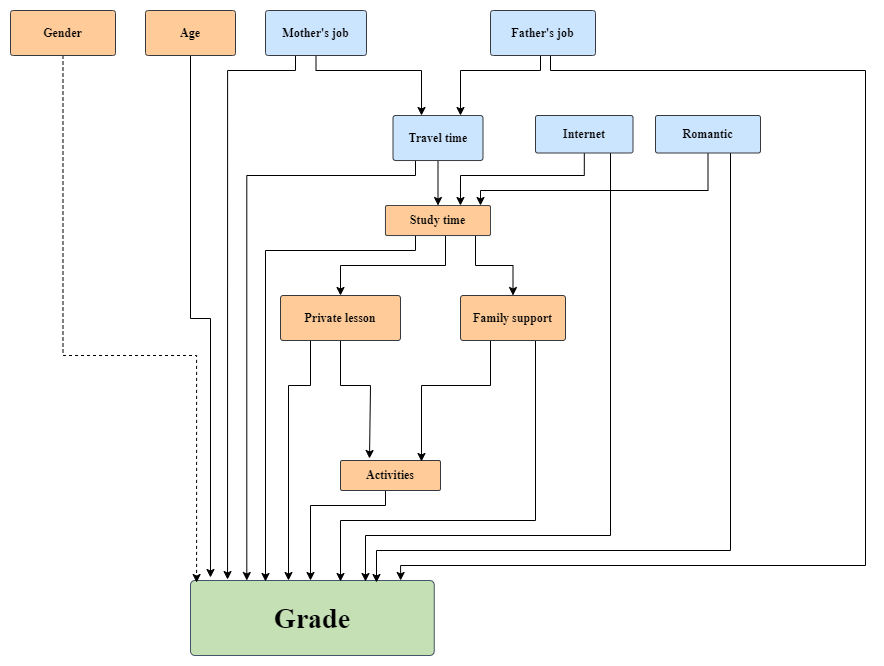

It's using the following designations:

On our dag we used following notation:

- green block - predicted data,

- orange block - additional predictors used in first model,
- blue block - predictor used in second model,

- interruption line - weak predictor

## Possible confoundings

- Fork

"Study time" influences both sense of "Private lesson" and "Family support"

- Collider

"Mother's job" and "Father's job" influence "Travel time".

"Study time" is infulenced by "Internet" and "Romantic"

"Activities: is influenced by "Private lesson" and "Family support"

- Pipe

"Mother's job" and "Father's job" influence "Travel time". This parameter influence "Study time".

# 2. Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from cmdstanpy import CmdStanModel
import scipy.stats as stats
import arviz as az
import math

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
# Set the display option to show all columns
pd.set_option('display.max_columns', None)


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data set analysis steps

Obviously, the database required some preprocessing before it could be used with acual models. It was necessary to perform a number of operations like reducing the size, handling missing values and transforming the data. Here are the main steps we took during this process:

1. Calculation of the average grade for the 3 study periods.
2. Restricting the scope of the data to needed columns and entries dating back to student's school GP (Gabriel Pereira).
3. Check and deleting if rows containing at least one null value.
4. Using Ordinal Encoding to assigning integer values to given categories for example "Fjob" (father's job) features.
5. Using One Hot Encoding to convert categorical for example: "address" (student's home address) features to binary variables.
6. Changing the data type of individual columns.

In [3]:
#read the data from the csv file
df = pd.read_csv("student-por.csv", sep=";")

# Filter out grades that were 0
df = df[~df['G3'].isin([0, 1])]

# Calculation of the average value of 3 assessments and addition of columns to the database
df['MeanGrade'] = df[['G1', 'G2', 'G3']].mean(axis=1)
df['MeanGrade'] = df['MeanGrade'].apply(lambda x: math.floor(x) if x > 0.5 else math.ceil(x))

# Show basic informations about data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 0 to 648
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      633 non-null    object
 1   sex         633 non-null    object
 2   age         633 non-null    int64 
 3   address     633 non-null    object
 4   famsize     633 non-null    object
 5   Pstatus     633 non-null    object
 6   Medu        633 non-null    int64 
 7   Fedu        633 non-null    int64 
 8   Mjob        633 non-null    object
 9   Fjob        633 non-null    object
 10  reason      633 non-null    object
 11  guardian    633 non-null    object
 12  traveltime  633 non-null    int64 
 13  studytime   633 non-null    int64 
 14  failures    633 non-null    int64 
 15  schoolsup   633 non-null    object
 16  famsup      633 non-null    object
 17  paid        633 non-null    object
 18  activities  633 non-null    object
 19  nursery     633 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,MeanGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,7
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,10
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,12


In [4]:
df.shape

(633, 34)

In [5]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df[col].value_counts())


Column Name: school
GP    421
MS    212
Name: school, dtype: int64

Column Name: sex
F    376
M    257
Name: sex, dtype: int64

Column Name: address
U    446
R    187
Name: address, dtype: int64

Column Name: famsize
GT3    443
LE3    190
Name: famsize, dtype: int64

Column Name: Pstatus
T    555
A     78
Name: Pstatus, dtype: int64

Column Name: Mjob
other       249
services    135
at_home     131
teacher      70
health       48
Name: Mjob, dtype: int64

Column Name: Fjob
other       359
services    175
at_home      41
teacher      35
health       23
Name: Fjob, dtype: int64

Column Name: reason
course        279
home          146
reputation    141
other          67
Name: reason, dtype: int64

Column Name: guardian
mother    444
father    149
other      40
Name: guardian, dtype: int64

Column Name: schoolsup
no     566
yes     67
Name: schoolsup, dtype: int64

Column Name: famsup
yes    393
no     240
Name: famsup, dtype: int64

Column Name: paid
no     595
yes     38
Name: paid, dty

## Columns reduction
To begin with, from the entire database we selected only those columns and rows that are meaningful to us, restricted the scope of the data to those of the "GP" school.

In [6]:
desired_columns = ["school", "sex", "age", "address", "Mjob", "Fjob", "traveltime", "studytime",
                   "schoolsup", "famsup", "activities", "internet", "romantic", "MeanGrade"]

# Selecting specific columns with rows only from GP
trimmed_df = df.loc[df['school'] == "GP", desired_columns]

# Displaying informations about database
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      421 non-null    object
 1   sex         421 non-null    object
 2   age         421 non-null    int64 
 3   address     421 non-null    object
 4   Mjob        421 non-null    object
 5   Fjob        421 non-null    object
 6   traveltime  421 non-null    int64 
 7   studytime   421 non-null    int64 
 8   schoolsup   421 non-null    object
 9   famsup      421 non-null    object
 10  activities  421 non-null    object
 11  internet    421 non-null    object
 12  romantic    421 non-null    object
 13  MeanGrade   421 non-null    int64 
dtypes: int64(4), object(10)
memory usage: 49.3+ KB


## Handling missing values

In our project, the most relevant parameter is the final MeanGrade. For this reason, we had to remove all rows in which the value for this column was unknown (NaN). In addition, we also checked the other columns for missing data.

In [7]:
# Dropping rows with missing values in one specific column (Grad)
trimmed_df = trimmed_df.dropna(subset = ['MeanGrade'])

# Checking how many missing values are in each column
nan_values_count = trimmed_df.isna().sum().sort_values(ascending = False)
info_df = pd.DataFrame(data = {"Column" : nan_values_count.index, "Null Count" : nan_values_count.values})

# Displaying informations about database
# display(info_df)
print("Number of all null values: {}".format(nan_values_count.values.sum()))
num_of_null_in_rows = trimmed_df.isnull().sum(axis = 1)
print("Number of rows with at least one null value: {}".format(len(trimmed_df[num_of_null_in_rows>0].index)))

Number of all null values: 0
Number of rows with at least one null value: 0


There are no null values in the dataset

In [8]:
# Resetting indexes
trimmed_df = trimmed_df.reset_index(drop = True)

## Data transformation
For cetegorical features "sex" (gender), "Mjob" (mother's job) and "Fjob" (father's job) , Ordinal Encoding was used.

In [9]:
## 'Gender' column encoding
print("\nUnique 'Gender' values before coding:\n{}".format(trimmed_df['sex'].unique()))

# Mapping dictionary (Female and Male)
gender_map = {"F" : 0,
              "M" : 1}

# Replacing categories with ordinal encdoded values
trimmed_df['sex'].replace(to_replace = gender_map, inplace = True)

print("\nUnique 'Gender' values after coding:\n{}".format(trimmed_df['sex'].unique()))


## 'Mother job' column encoding
print("\nUnique 'Mother job' values before coding:\n{}".format(trimmed_df['Mjob'].unique()))

# Mapping dictionary ()
Mjob_map = {"teacher" : 1,
            "health" : 2,
            "services" : 3,
            "at_home" : 4,
            "other" : 5}

# Replacing categories with ordinal encdoded values
trimmed_df['Mjob'].replace(to_replace = Mjob_map, inplace = True)

print("\nUnique 'Mother job' values after coding:\n{}".format(trimmed_df['Mjob'].unique()))


## 'Father job' column encoding
print("\nUnique 'Father job' values before coding:\n{}".format(trimmed_df['Fjob'].unique()))

# Mapping dictionary ()
Fjob_map = {"teacher" : 1,
            "health" : 2,
            "services" : 3,
            "at_home" : 4,
            "other" : 5}

# Replacing categories with ordinal encdoded values
trimmed_df['Fjob'].replace(to_replace = Fjob_map, inplace = True)

print("\nUnique 'Father job' values after coding:\n{}".format(trimmed_df['Fjob'].unique()))



Unique 'Gender' values before coding:
['F' 'M']

Unique 'Gender' values after coding:
[0 1]

Unique 'Mother job' values before coding:
['at_home' 'health' 'other' 'services' 'teacher']

Unique 'Mother job' values after coding:
[4 2 5 3 1]

Unique 'Father job' values before coding:
['teacher' 'other' 'services' 'health' 'at_home']

Unique 'Father job' values after coding:
[1 5 3 2 4]


Unlike previous case - features for example: "schoolsup" and "famsup" an another in dataset are nominal (do not have any order). Therefore, One Hot Encoding was used to mapp each category with a binary variable containing either 0 or 1.

In [10]:
# 'address' column encoding - (student's home address type (binary: 'U' - urban or 'R' - rural))
address_enc = pd.get_dummies(data = trimmed_df['address'], drop_first=True)
address_enc.rename(columns = {'U' : 'address'}, inplace=True)

print("Unique 'address' values before coding:\n{}".format(trimmed_df['address'].unique()))
trimmed_df = trimmed_df.drop('address', axis=1)
trimmed_df = pd.concat([trimmed_df, address_enc], axis=1)
print("\nUnique 'address' values after coding:\n{}".format(trimmed_df['address'].unique()))


# 'schoolsup' column encoding - extra educational support (binary: yes or no)
schoolsup_enc = pd.get_dummies(data=trimmed_df['schoolsup'], drop_first=True)
schoolsup_enc.rename(columns={'yes': 'schoolsup'}, inplace=True)

print("\nUnique 'schoolsup' values before coding:\n{}".format(trimmed_df['schoolsup'].unique()))
trimmed_df = trimmed_df.drop('schoolsup', axis=1)
trimmed_df = pd.concat([trimmed_df, schoolsup_enc], axis=1)
print("\nUnique 'schoolsup' values after coding:\n{}".format(trimmed_df['schoolsup'].unique()))


# 'famsup' column encoding - family educational support (binary: yes or no)
famsup_enc = pd.get_dummies(data=trimmed_df['famsup'], drop_first=True)
famsup_enc.rename(columns={'yes': 'famsup'}, inplace=True)

print("\nUnique 'famsup' values before coding:\n{}".format(trimmed_df['famsup'].unique()))
trimmed_df = trimmed_df.drop('famsup', axis=1)
trimmed_df = pd.concat([trimmed_df, famsup_enc], axis=1)
print("\nUnique 'famsup' values after coding:\n{}".format(trimmed_df['famsup'].unique()))


# 'activities' column encoding - extra-curricular activities (binary: yes or no)
activities_enc = pd.get_dummies(data=trimmed_df['activities'], drop_first=True)
activities_enc.rename(columns={'yes': 'activities'}, inplace=True)

print("\nUnique 'activities' values before coding:\n{}".format(trimmed_df['activities'].unique()))
trimmed_df = trimmed_df.drop('activities', axis=1)
trimmed_df = pd.concat([trimmed_df, activities_enc], axis=1)
print("\nUnique 'activities' values after coding:\n{}".format(trimmed_df['activities'].unique()))


# 'internet' column encoding - Internet access at home (binary: yes or no)
internet_enc = pd.get_dummies(data=trimmed_df['internet'], drop_first=True)
internet_enc.rename(columns={'yes': 'internet'}, inplace=True)

print("\nUnique 'internet' values before coding:\n{}".format(trimmed_df['internet'].unique()))
trimmed_df = trimmed_df.drop('internet', axis=1)
trimmed_df = pd.concat([trimmed_df, internet_enc], axis=1)
print("\nUnique 'internet' values after coding:\n{}".format(trimmed_df['internet'].unique()))


# 'romantic' column encoding - with a romantic relationship (binary: yes or no)
romantic_enc = pd.get_dummies(data=trimmed_df['romantic'], drop_first=True)
romantic_enc.rename(columns={'yes': 'romantic'}, inplace=True)

print("\nUnique 'romantic' values before coding:\n{}".format(trimmed_df['romantic'].unique()))
trimmed_df = trimmed_df.drop('romantic', axis=1)
trimmed_df = pd.concat([trimmed_df, romantic_enc], axis=1)
print("\nUnique 'romantic' values after coding:\n{}".format(trimmed_df['romantic'].unique()))


Unique 'address' values before coding:
['U' 'R']

Unique 'address' values after coding:
[1 0]

Unique 'schoolsup' values before coding:
['yes' 'no']

Unique 'schoolsup' values after coding:
[1 0]

Unique 'famsup' values before coding:
['no' 'yes']

Unique 'famsup' values after coding:
[0 1]

Unique 'activities' values before coding:
['no' 'yes']

Unique 'activities' values after coding:
[0 1]

Unique 'internet' values before coding:
['no' 'yes']

Unique 'internet' values after coding:
[0 1]

Unique 'romantic' values before coding:
['no' 'yes']

Unique 'romantic' values after coding:
[0 1]


At the end data types of individual columns have been changed.

In [11]:
# Displaying informations about database
display(trimmed_df.dtypes)
trimmed_df.head()

school        object
sex            int64
age            int64
Mjob           int64
Fjob           int64
traveltime     int64
studytime      int64
MeanGrade      int64
address        uint8
schoolsup      uint8
famsup         uint8
activities     uint8
internet       uint8
romantic       uint8
dtype: object

,school,sex,age,Mjob,Fjob,traveltime,studytime,MeanGrade,address,schoolsup,famsup,activities,internet,romantic
0,GP,0,18,4,1,2,2,7,1,1,0,0,0,0
1,GP,0,17,4,5,1,2,10,1,0,1,0,1,0
2,GP,0,15,4,5,1,2,12,1,1,0,0,1,0
3,GP,0,15,2,3,1,3,14,1,0,1,1,1,1
4,GP,0,16,5,5,1,2,12,1,0,1,0,0,0


In the end, data preprocessing resulted in a set with 14 columns and 421 entries. In order to achieve this, a number of operations were necessary, such as reducing the dimensions of the database, getting rid of rows/columns with missing values, and transforming some features into other data types.

## Plot histogram for columns of dataFrame

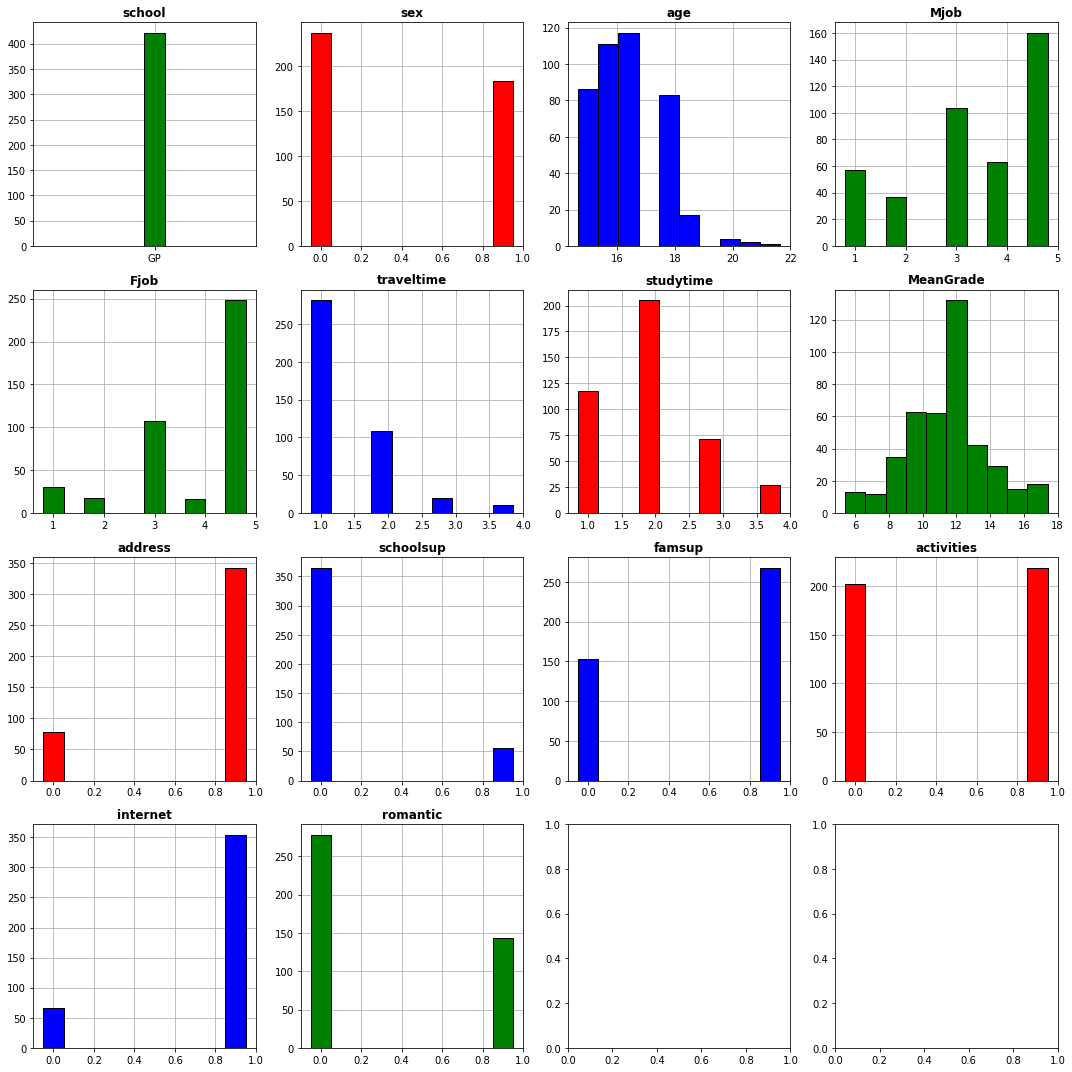

,school,sex,age,Mjob,Fjob,traveltime,studytime,MeanGrade,address,schoolsup,famsup,activities,internet,romantic
0,GP,0,18,4,1,2,2,7,1,1,0,0,0,0
1,GP,0,17,4,5,1,2,10,1,0,1,0,1,0
2,GP,0,15,4,5,1,2,12,1,1,0,0,1,0
3,GP,0,15,2,3,1,3,14,1,0,1,1,1,1
4,GP,0,16,5,5,1,2,12,1,0,1,0,0,0


In [12]:
# Iterate over columns of dataFrame and plot histogram for each of it
num_rows = 4
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

row_index = 0
col_index = 0

for (colname, colval) in trimmed_df.iteritems():
    axs[row_index, col_index].hist(colval.values, align='left', color=np.random.choice(['red', 'green', 'blue']), edgecolor="black", zorder=3)
    axs[row_index, col_index].set_title(colname, fontweight="bold")
    axs[row_index, col_index].grid(zorder=0)

    col_index += 1
    if col_index == num_cols:
        col_index = 0
        row_index += 1
        if row_index == num_rows:
            break

plt.tight_layout()
plt.show()

trimmed_df.head()

## Grade Distribution final MeanGrade

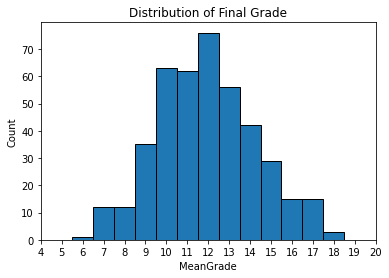

In [13]:
# Bar plot of grades
plt.bar(trimmed_df['MeanGrade'].value_counts().index,
        trimmed_df['MeanGrade'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('MeanGrade'); plt.ylabel('Count'); plt.title('Distribution of Final Grade');
plt.xticks(list(range(4, 21)));
plt.show()

## Grade Distribution by Different Categorical Variables

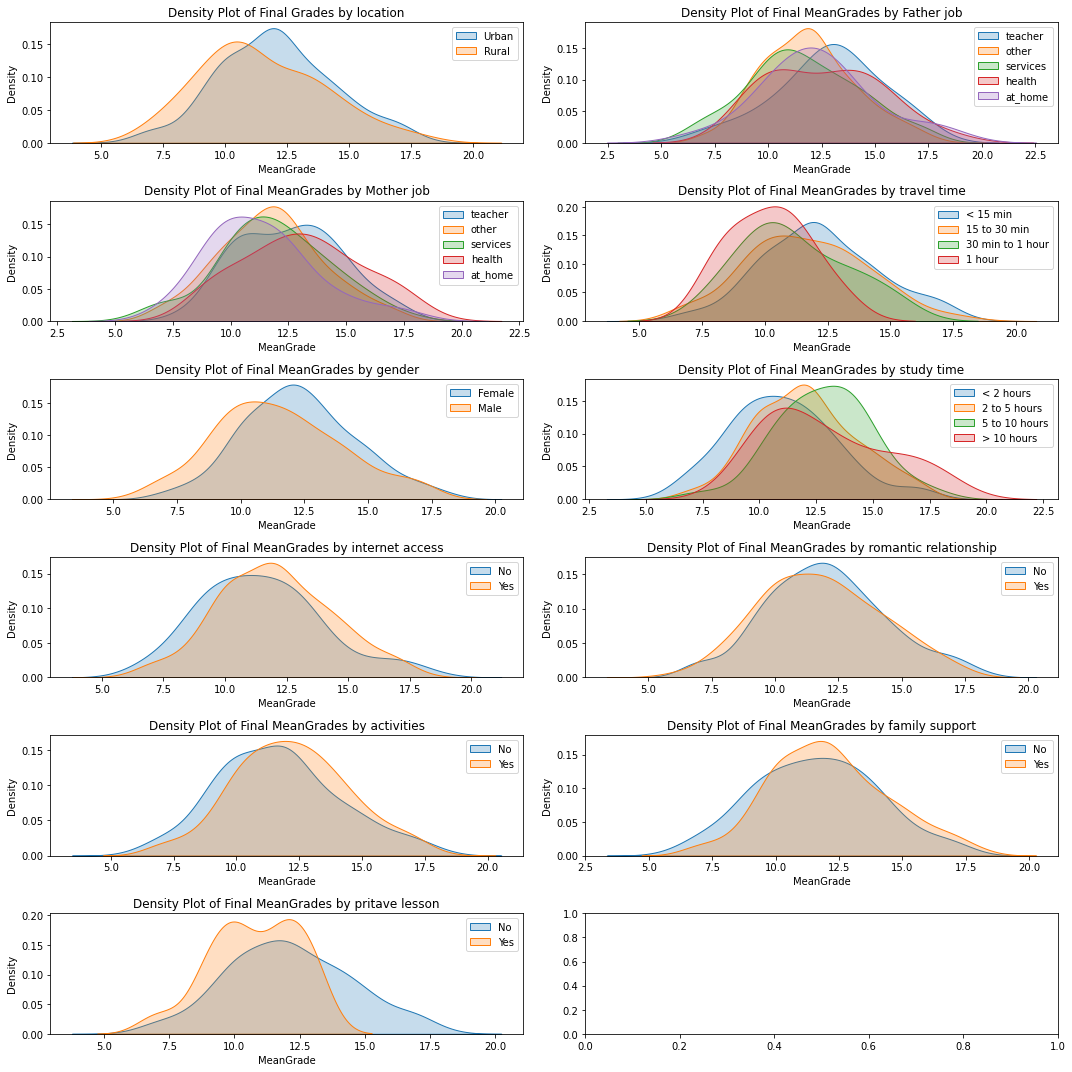

In [14]:
fig, axes = plt.subplots(6, 2, figsize=(15, 15))

# Plot 1: Grade distribution by address
sns.kdeplot(trimmed_df.loc[trimmed_df['address'] == 1, 'MeanGrade'], label='Urban', fill=True, ax=axes[0, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['address'] == 0, 'MeanGrade'], label='Rural', fill=True, ax=axes[0, 0])
axes[0, 0].set_xlabel('MeanGrade')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Density Plot of Final Grades by location')
axes[0, 0].legend(labels=['Urban', 'Rural'])

# Plot 2: Grade distribution by Father job
sns.kdeplot(trimmed_df.loc[trimmed_df['Fjob'] == 1, 'MeanGrade'], label='teacher', fill=True, ax=axes[0, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['Fjob'] == 5, 'MeanGrade'], label='other', fill=True, ax=axes[0, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['Fjob'] == 3, 'MeanGrade'], label='services', fill=True, ax=axes[0, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['Fjob'] == 2, 'MeanGrade'], label='health', fill=True, ax=axes[0, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['Fjob'] == 4, 'MeanGrade'], label='at_home', fill=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('MeanGrade')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Density Plot of Final MeanGrades by Father job')
axes[0, 1].legend()

# Plot 3: Grade distribution by Mother job
sns.kdeplot(trimmed_df.loc[trimmed_df['Mjob'] == 1, 'MeanGrade'], label='teacher', fill=True, ax=axes[1, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['Mjob'] == 5, 'MeanGrade'], label='other', fill=True, ax=axes[1, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['Mjob'] == 3, 'MeanGrade'], label='services', fill=True, ax=axes[1, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['Mjob'] == 2, 'MeanGrade'], label='health', fill=True, ax=axes[1, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['Mjob'] == 4, 'MeanGrade'], label='at_home', fill=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('MeanGrade')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Density Plot of Final MeanGrades by Mother job')
axes[1, 0].legend()

# Plot 4: Grade distribution by Travel Time
sns.kdeplot(trimmed_df.loc[trimmed_df['traveltime'] == 1, 'MeanGrade'], label='< 15 min', fill=True, ax=axes[1, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['traveltime'] == 2, 'MeanGrade'], label='15 to 30 min', fill=True, ax=axes[1, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['traveltime'] == 3, 'MeanGrade'], label='30 min to 1 hour', fill=True, ax=axes[1, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['traveltime'] == 4, 'MeanGrade'], label='1 hour', fill=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('MeanGrade')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Density Plot of Final MeanGrades by travel time')
axes[1, 1].legend()

# Plot 5: Grade distribution by Gender
sns.kdeplot(trimmed_df.loc[trimmed_df['sex'] == 0, 'MeanGrade'], label='Female', fill=True, ax=axes[2, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['sex'] == 1, 'MeanGrade'], label='Male', fill=True, ax=axes[2, 0])
axes[2, 0].set_xlabel('MeanGrade')
axes[2, 0].set_ylabel('Density')
axes[2, 0].set_title('Density Plot of Final MeanGrades by gender')
axes[2, 0].legend()

# Plot 6: Grade distribution by Study Time
sns.kdeplot(trimmed_df.loc[trimmed_df['studytime'] == 1, 'MeanGrade'], label='< 2 hours', fill=True, ax=axes[2, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['studytime'] == 2, 'MeanGrade'], label='2 to 5 hours', fill=True, ax=axes[2, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['studytime'] == 3, 'MeanGrade'], label='5 to 10 hours', fill=True, ax=axes[2, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['studytime'] == 4, 'MeanGrade'], label='> 10 hours', fill=True, ax=axes[2, 1])
axes[2, 1].set_xlabel('MeanGrade')
axes[2, 1].set_ylabel('Density')
axes[2, 1].set_title('Density Plot of Final MeanGrades by study time')
axes[2, 1].legend()

# Plot 7: Grade distribution by Internet acces
sns.kdeplot(trimmed_df.loc[trimmed_df['internet'] == 0, 'MeanGrade'], label='No', fill=True, ax=axes[3, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['internet'] == 1, 'MeanGrade'], label='Yes', fill=True, ax=axes[3, 0])
axes[3, 0].set_xlabel('MeanGrade')
axes[3, 0].set_ylabel('Density')
axes[3, 0].set_title('Density Plot of Final MeanGrades by internet access')
axes[3, 0].legend()

# Plot 8: Grade distribution by romantic relationship
sns.kdeplot(trimmed_df.loc[trimmed_df['romantic'] == 0, 'MeanGrade'], label='No', fill=True, ax=axes[3, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['romantic'] == 1, 'MeanGrade'], label='Yes', fill=True, ax=axes[3, 1])
axes[3, 1].set_xlabel('MeanGrade')
axes[3, 1].set_ylabel('Density')
axes[3, 1].set_title('Density Plot of Final MeanGrades by romantic relationship')
axes[3, 1].legend()

# Plot 9: Grade distribution by activities
sns.kdeplot(trimmed_df.loc[trimmed_df['activities'] == 0, 'MeanGrade'], label='No', fill=True, ax=axes[4, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['activities'] == 1, 'MeanGrade'], label='Yes', fill=True, ax=axes[4, 0])
axes[4, 0].set_xlabel('MeanGrade')
axes[4, 0].set_ylabel('Density')
axes[4, 0].set_title('Density Plot of Final MeanGrades by activities')
axes[4, 0].legend()

# Plot 10: Grade distribution by Family support
sns.kdeplot(trimmed_df.loc[trimmed_df['famsup'] == 0, 'MeanGrade'], label='No', fill=True, ax=axes[4, 1])
sns.kdeplot(trimmed_df.loc[trimmed_df['famsup'] == 1, 'MeanGrade'], label='Yes', fill=True, ax=axes[4, 1])
axes[4, 1].set_xlabel('MeanGrade')
axes[4, 1].set_ylabel('Density')
axes[4, 1].set_title('Density Plot of Final MeanGrades by family support')
axes[4, 1].legend()

# Plot 11: Grade distribution by private lesson
sns.kdeplot(trimmed_df.loc[trimmed_df['schoolsup'] == 0, 'MeanGrade'], label='No', fill=True, ax=axes[5, 0])
sns.kdeplot(trimmed_df.loc[trimmed_df['schoolsup'] == 1, 'MeanGrade'], label='Yes', fill=True, ax=axes[5, 0])
axes[5, 0].set_xlabel('MeanGrade')
axes[5, 0].set_ylabel('Density')
axes[5, 0].set_title('Density Plot of Final MeanGrades by pritave lesson')
axes[5, 0].legend()


plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [15]:
trimmed_df['MeanGrade'].describe()

count    421.000000
mean      11.935867
std        2.372094
min        6.000000
25%       10.000000
50%       12.000000
75%       13.000000
max       18.000000
Name: MeanGrade, dtype: float64

## Create Correlation Matrix

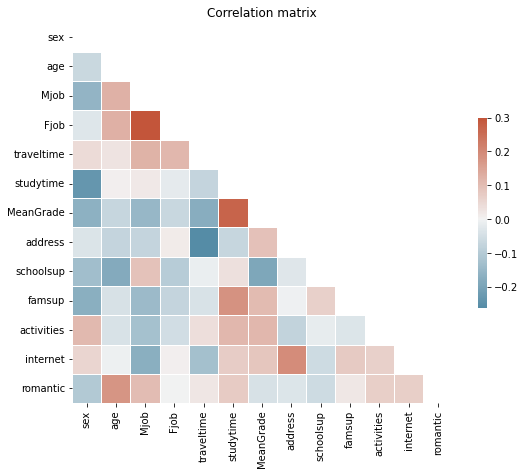

In [16]:
# Correlation between all variables
corr = trimmed_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation matrix")
plt.show()

From the analysis of the correlation matrix, we can observe that the direct level of correlation between the selected variables is not very strong. This behavior is desired because our ordered logistic regression models require low association between features.

To understand why the main diagonal (correlation values between the same variables) is removed before generating the heatmap, we need to consider that the correlation between variables and themselves always equals 1.

# 3. Models description - priors and validation

## Priors selected

We have opted for using uninformative or "weak" priors in our model for the predictor coefficients. Specifically, we have chosen a normal distribution with a mean of 0 and a standard deviation of 1 for most of the predictor coefficients, except for the cutpoints, where we use a standard deviation of 3. The reason behind this choice is that we couldn't obtain any specific or informative values for these parameters.

By employing uninformative priors, we essentially express our uncertainty about the true values of the coefficients. It allows us to consider a relatively wide range of plausible values along the real number line, without imposing strong assumptions on the data. This approach is especially useful when we lack prior knowledge or domain expertise to inform the choice of priors.

The values for the cutpoints (c) are defined directly in the model because we cannot use an ordered vector in the generated quantities block.

## Ordered logistics regression

We have decied to use ordered logistics regression analysis in order to determine factors affecting final performance level of MeanGrade. For example, this has already been addressed in other scientific material:
 https://www.researchgate.net/publication/349165307_An_Ordinal_Logistic_Regression_Model_to_Identify_Factors_Influencing_Students_Academic_Performance_at_Njala_University

Ordered logistic reggression model is used when varabile has more than two categories and is sortable. In our case for example we have 5 diffrent levels of father and mother job, and we can sort them. Other use case for such models would be predicting studytime (weekly study time) of parameters with outcomes as: ( 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours).

We are loooking for values of cutpoints which would split values of linear combination for given person into 20 categories.

## 3.1 First model

This is a Bayesian ordinal logistic regression model implemented in Stan, which aims to predict an ordinal outcome based on 6 predictors (age, gender, extra educational support, extra educational support, extra educational support, activities). The model, defined by specific cutpoints and coefficients for each predictor, assumes priors to follow a normal distribution. The estimation process uses a loop to run through all observations, calculating the sum of each predictor times its respective coefficient for the ordinal logistic regression model.

### Inputs:
- N - Number of samples
- K - Number of ordinal categories
- y[N] - Ordinal outcome
- age_pred[N] - Predictor 1 (age)
- gender_pred[N] - Predictor 2 (gender)
- schoolsup_pred[N] - Predictor 3 (extra educational support)
- famsup_pred[N] - Predictor 4 (family educational support)
- studytime_pred[N] - Predictor 5 (weekly study time)
- activities_pred[N] - Predictor 6 (extra-curricular activities)

### Parameters:
- c[K-1] - Cutpoints
- coef_age - Coefficient 1 (age)
- coef_gender - Coefficient 2 (gender)
- coef_schoolsup - Coefficient 3 (extra educational support)
- real coef_famsup - Coefficient 4 (family educational support)
- coef_studytime[5] - Coefficient 5 (weekly study time)
- coef_activity[5] - Coefficient 6 (extra-curricular activities)

### Formulas:
```
  grade = ordered_logistic(coef_studytime[studytime_pred] +    
                           coef_age * age_pred +
                           coef_gender * gender_pred +
                           coef_schoolsup * schoolsup_pred +
                           coef_famsup * famsup_pred
                           coef_activity * activities_pred, c);
```


$$c \sim Normal(0, 3)$$
$$coef_{age} \sim Normal(0, 1)$$
$$coef_{gender} \sim Normal(0, 1)$$
$$coef_{schoolsup} \sim Normal(0, 1)$$
$$coef_{famsup} \sim Normal(0, 1)$$
$$coef_{studytime} \sim Normal(0, 1)$$
$$coef_{activity} \sim Normal(0, 1)$$

## 3.2 Second model
The other model is supposed to extend the first one. By adding more parameters (information about final MeanGrade) - we chose normal distribution. We wanted to see if it would improve prediction or overcomplicate the model.

For second model we have added internet, romantic, traveltime, job mother, job father. These parameters can have impact on final student performance MeanGrade.

### Inputs:
- N - Number of samples
- K - Number of ordinal categories
- y[N] - Ordinal outcome
- age_pred[N] - Predictor 1 (age)
- gender_pred[N] - Predictor 2 (gender)
- schoolsup_pred[N] - Predictor 3 (extra educational support)
- famsup_pred[N] - Predictor 4 (family educational support)
- studytime_pred[N] - Predictor 5 (weekly study time)
- internet_pred[N] - Predictor 6 (Internet access at home)
- romantic_pred[N] - Predictor 7 (with a romantic relationship)
- traveltime_pred[N] - Predictor 8 (home to school travel time)
- activities_pred[N] - Predictor 9 (extra-curricular activities)
- int Mjob_pred[N] - Predictor 10 (mother's job)
- int Fjob_pred[N] - Predictor 11 (father's job)

### Parameters:
- c[K-1] - Cutpoints
- coef_age - Coefficient 1 (age)
- coef_gender - Coefficient 2 (gender)
- coef_schoolsup - Coefficient 3 (extra educational support)
- real coef_famsup - Coefficient 4 (family educational support)
- coef_studytime[5] - Coefficient 5 (weekly study time)
- coef_internet - Coefficient 6 (Internet access at home)
- coef_romantic - Coefficient 7 (with a romantic relationship)
- coef_activities - Coefficient 8 (extra-curricular activities)
- coef_traveltime[4] - Coefficient 9 (home to school travel time)
- coef_Mjob[5] - Coefficient 10 (mother's job)
- coef_Fjob[5] - Coefficient 11 (father's job)

### Formulas:
```
  grade = ordered_logistic_rng(coef_studytime[studytime_pred[n]] +
                               coef_traveltime[traveltime_pred[n]] +
                               coef_Mjob[Mjob_pred[n]] +
                               coef_Fjob[Fjob_pred[n]] +
                               coef_age * age_pred[n] +
                               coef_gender * gender_pred[n] +
                               coef_schoolsup * schoolsup_pred[n] +
                               coef_famsup * famsup_pred[n] +
                               coef_internet * internet_pred[n] +
                               coef_romantic * romantic_pred[n] +
                               coef_activities * activities_pred[n], c);
```


$$c \sim Normal(0, 3)$$
$$coef_{age} \sim Normal(0, 1)$$
$$coef_{gender} \sim Normal(0, 1)$$
$$coef_{schoolsup} \sim Normal(0, 1)$$
$$coef_{famsup} \sim Normal(0, 1)$$
$$coef_{studytime} \sim Normal(0, 1)$$

$$coef_{internet} \sim Normal(0, 1)$$
$$coef_{romantic} \sim Normal(0, 1)$$
$$coef_{activities} \sim Normal(0, 1)$$
$$coef_{traveltime} \sim Normal(0, 1)$$
$$coef_{Mjob} \sim Normal(0, 1)$$
$$coef_{Fjob} \sim Normal(0, 1)$$

# 4. Model 1 - Prior predictive check




In [17]:
with open('model1_ppc.stan') as file:
    print(file.read())

data { 
  // Output related data
  int K;  // number of ordinal categories
  int y;  // ordinal outcome

  // Predictors (1-6)
  real age_pred;             // Predictor 1 (age)
  int gender_pred;           // Predictor 2 (gender)
  int schoolsup_pred;        // Predictor 3 (extra educational support)
  int famsup_pred;           // Predictor 4 (family educational support)
  int studytime_pred;        // Predictor 5 (weekly study time)
  int activities_pred;              // Predictor 6 (activity)
}

parameters {
  ordered[K-1] c;
}

model {
  c ~ uniform(-25, 25);
}

generated quantities{
  // // Coefficients for predictors (1-5)

  real coef_age = normal_rng(0, 1);            // Coefficient 1 (age)
  real coef_gender = normal_rng(0, 1);         // Coefficient 2 (gender)
  real coef_schoolsup = normal_rng(0, 1);      // Coefficient 3 (extra educational support)
  real coef_famsup = normal_rng(0, 1);         // Coefficient 4 (family educational support)
  real coef_activity = normal_rng(

In [18]:
N = 421
main_df = trimmed_df.head(N)

# All database columns
Final_grade = main_df['MeanGrade'].to_numpy()
Age = main_df['age'].to_numpy()
Gender = main_df['sex'].to_numpy()
Schoolsup = main_df['schoolsup'].to_numpy()
Famsup = main_df['famsup'].to_numpy()
Studytime = main_df['studytime'].to_numpy()
Activities  = main_df['activities'].to_numpy()


Internet = main_df['internet'].to_numpy()
Romanitc = main_df['romantic'].to_numpy()
Traveltime = main_df['traveltime'].to_numpy()
JobMother = main_df['Mjob'].to_numpy()
JobFather = main_df['Fjob'].to_numpy()

# Normalization
Age = (Age - Age.mean(axis=0)) / Age.std(axis=0)


In [19]:
model1_ppc = CmdStanModel(stan_file='model1_ppc.stan')

rng_num =  np.random.randint(low=0, high=100)

d = {'K' : 20,
     'y' : Final_grade[rng_num],
     'age_pred' : Age[rng_num],
     'gender_pred' : Gender[rng_num],
     'schoolsup_pred' : Schoolsup[rng_num],
     'famsup_pred' : Famsup[rng_num],
     'studytime_pred' : Studytime[rng_num],
     'activities_pred': Activities[rng_num]}

model1_ppc_sim = model1_ppc.sample(data = d,
                                   iter_sampling=1000,
                                   chains=4,
                                   fixed_param=True,
                                   seed=20230715)


chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration: 200 / 1000 [ 20%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

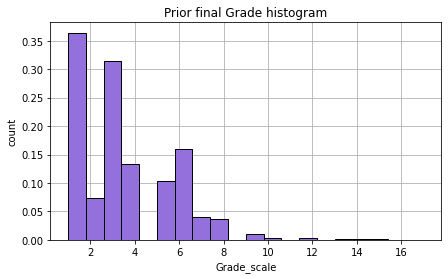

In [20]:
ppc_final_grade = model1_ppc_sim.stan_variable('grade').flatten()
plt.figure(figsize=(7, 4))

x, y = np.unique(Final_grade, return_counts=True)
plt.hist(ppc_final_grade, bins=20, align='mid', density=True, label='predicted', color='mediumpurple', edgecolor="black", zorder=2)
plt.title("Prior final Grade histogram")
plt.xlabel("Grade_scale")
plt.ylabel("count")
plt.grid(zorder=0)
plt.show()


For random choosen sample prior predictive check does not fit data very well. The main reason behind this behaviour are choosen priors. Model does not yet know that beta paramteres in vector for each categorical variable could be correlated.

## Prior parameteres check

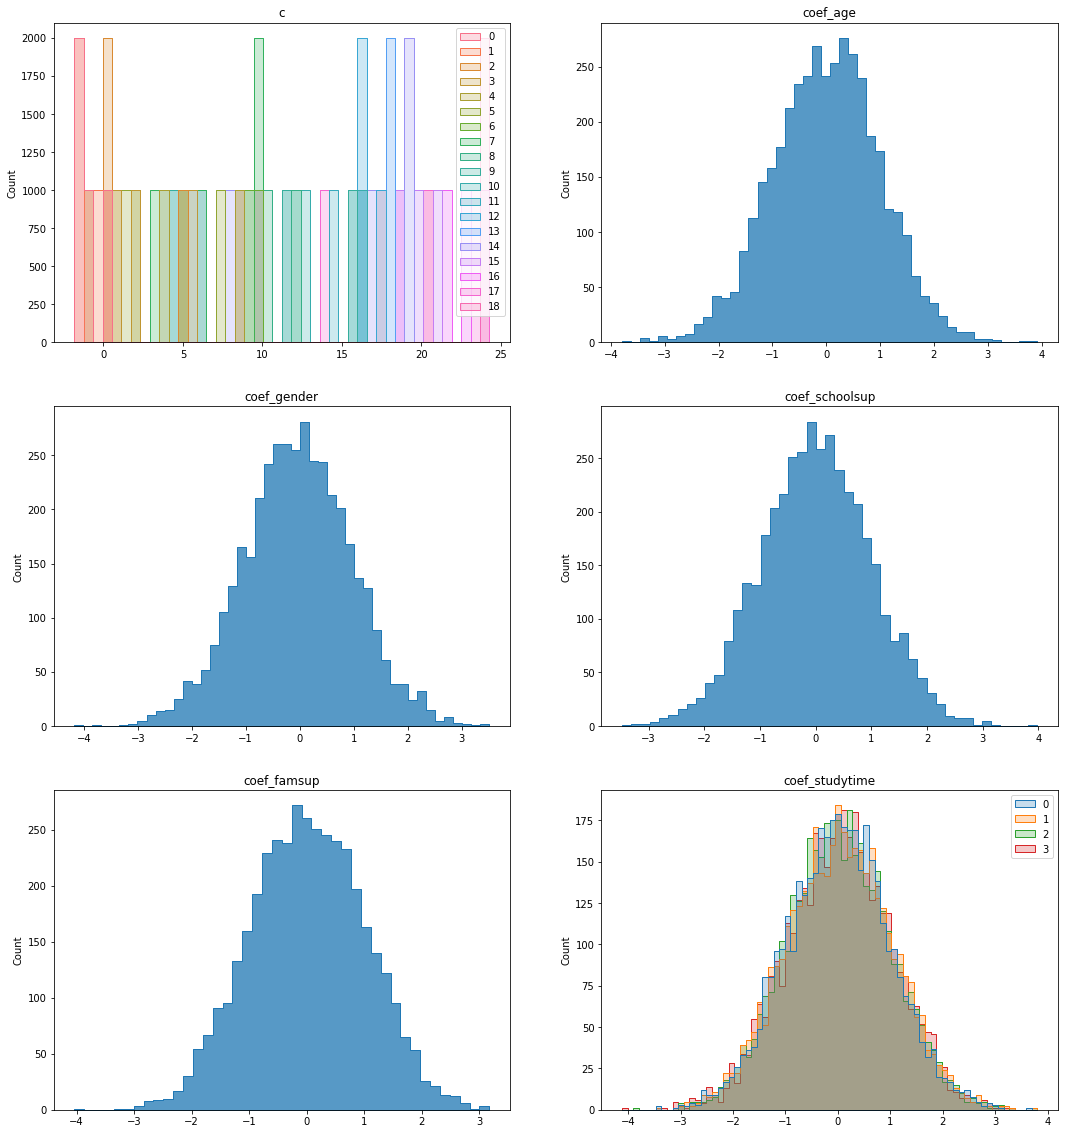

In [21]:
lst = ['c','coef_age','coef_gender','coef_schoolsup','coef_famsup','coef_studytime', 'coef_activity']
fig, axs = plt.subplots(3, 2, figsize=(18, 20))

for ax, param in zip(axs.flat, lst):
 coeffs = model1_ppc_sim.stan_variable(param)
 sns.histplot(ax=ax, data=coeffs, element="step")
 ax.set_title(param)

plt.show()

Distribution of coefficients in prior model are consistent with those specfied in model.

C - cutoff does not change because it can only be specified in model (it is an oredered vector), and we do not want to update it in prior predictive check.

# 5. Model 1 - Posterior analysis

In first model we have decied to use: age, gender, extra educational support, family educational support, weekly study time, activities. MeanGrade is an ordered categorical variable, therefore we have used ordered logistic model.

This model is suited for categorical variable, we are searching beta parameters for each coefficient and cutoffpoints which define values in which the level of MeanGrade changes.

In [2]:
with open('model1_fit.stan') as file:
    print(file.read())

data {
  // Number of observations
  int<lower=0> N;

  // Output related data
  int K;                  // Number of ordinal categories
  array[N] int y;         // Ordinal outcome

  // Predictors (1-6)
  array[N] real age_pred;             // Predictor 1 (age)
  array[N] int gender_pred;           // Predictor 2 (gender)
  array[N] int schoolsup_pred;        // Predictor 3 (extra educational support)
  array[N] int famsup_pred;           // Predictor 4 (family educational support)
  array[N] int studytime_pred;        // Predictor 5 (weekly study time)
  array[N] int activities_pred;       // Predictor 6 (activities)
}

parameters {
  ordered[K-1] c;               // cutpoints

  // Coefficients for predictors (1-6)
  real coef_age;                // Coefficient 1 (age)
  real coef_gender;             // Coefficient 2 (gender)
  real coef_schoolsup;          // Coefficient 3 (extra educational support)
  real coef_famsup;             // Coefficient 4 (family educational support)
  r

In [23]:
model1_fit = CmdStanModel(stan_file='model1_fit.stan')

d = {'N' : N,
     'K' : 20,
     'y' : Final_grade,
     'age_pred' : Age,
     'gender_pred' : Gender,
     'schoolsup_pred' : Schoolsup,
     'famsup_pred' : Famsup,
     'studytime_pred' : Studytime,
     'activities_pred': Activities}

# Compilation of model1_fit.stan
model1_fit_sim = model1_fit.sample(data = d,
                                   iter_sampling=500,
                                   iter_warmup=500,
                                   chains=2,
                                   adapt_delta=0.99,
                                   seed=20230715)


chain 1 |██████████| 02:23 Sampling completed                      
chain 2 |██████████| 02:23 Sampling completed                      

In [24]:
print(model1_fit_sim.diagnose())

Processing csv files: /tmp/tmphc62z64t/model1_fit51_5v_6r/model1_fit-20230720004405_1.csv, /tmp/tmphc62z64t/model1_fit51_5v_6r/model1_fit-20230720004405_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



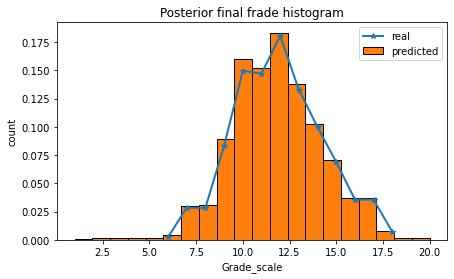

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0   -956.176       0.995484    0.015909          8.0         255.0   
1   -955.331       0.999530    0.015909          8.0         255.0   
2   -961.509       0.988147    0.015909          8.0         255.0   
3   -952.381       0.981480    0.015909          7.0         255.0   
4   -955.395       0.998407    0.015909          8.0         255.0   
..       ...            ...         ...          ...           ...   
995 -956.237       0.992597    0.013332          8.0         255.0   
996 -959.951       0.992397    0.013332          8.0         255.0   
997 -955.566       0.999585    0.013332          8.0         255.0   
998 -956.442       0.999877    0.013332          8.0         255.0   
999 -957.535       0.999977    0.013332          8.0         255.0   

     divergent__  energy__     c[1]     c[2]     c[3]     c[4]     c[5]  \
0            0.0   981.131 -7.02215 -5.97154 -4.87184 -4.71487 -4.67746   
1            0.0   965.231 -8.70510 -7.86071 -7.61360 -6.59582 -5.43243   
2            0.0   975.459 -6.20442 -5.99514 -4.65566 -4.59077 -4.49111   
3            0.0   972.147 -7.26196 -6.24290 -5.66403 -5.57288 -4.98493   
4            0.0   963.603 -7.90843 -7.46500 -6.85098 -4.90070 -4.84579   
..           ...       ...      ...      ...      ...      ...      ...   
995          0.0   974.509 -6.18552 -5.43950 -5.33689 -5.13857 -4.64744   
996          0.0   971.969 -8.02507 -7.73198 -7.56450 -5.04811 -5.00230   
997          0.0   970.660 -7.04023 -6.68796 -6.51005 -5.53247 -5.46244   
998          0.0   965.086 -6.73533 -6.39450 -6.13824 -5.19255 -5.13616   
999          0.0   969.454 -7.90720 -7.11794 -6.03453 -5.92348 -5.36894   

        c[6]     c[7]     c[8]      c[9]     c[10]     c[11]     c[12]  \
0   -4.51816 -3.22129 -2.78527 -2.079950 -1.144020 -0.385017  0.365471   
1   -4.14523 -2.85573 -2.30579 -0.989792  0.004099  0.674867  1.508420   
2   -4.18336 -3.06077 -2.48760 -1.664090 -0.918059 -0.187994  0.596189   
3   -4.68140 -3.01541 -2.14401 -1.153700 -0.305614  0.409073  1.181690   
4   -4.73192 -3.34528 -2.40736 -1.487290 -0.610230  0.125240  0.845338   
..       ...      ...      ...       ...       ...       ...       ...   
995 -4.41195 -3.14841 -2.40104 -1.514900 -0.591104  0.247829  1.042390   
996 -4.69121 -3.15090 -2.53401 -1.803010 -0.926460 -0.226961  0.570525   
997 -5.06353 -3.48974 -2.92561 -2.164710 -1.268390 -0.530038  0.262777   
998 -4.93886 -3.64160 -2.90029 -2.111460 -1.189600 -0.439617  0.275939   
999 -4.44971 -3.12411 -2.69383 -1.583270 -0.576652  0.001575  0.863448   

       c[13]    c[14]    c[15]    c[16]    c[17]    c[18]     c[19]  coef_age  \
0    1.06486  1.57505  2.24967  3.20066  4.44520  5.98351   6.56017 -0.241035   
1    2.18086  3.00698  3.70094  4.13533  5.85949  7.05322   8.20035 -0.243833   
2    1.35794  1.79617  2.65121  3.21202  4.65371  6.41921   6.47918 -0.119793   
3    1.89421  2.47405  3.22201  3.93154  5.43705  6.64258   6.70260 -0.176589   
4    1.53775  2.27107  3.03964  3.88219  5.09821  6.93467   7.11628 -0.183261   
..       ...      ...      ...      ...      ...      ...       ...       ...   
995  1.76180  2.25596  2.99892  3.75467  5.19723  6.60460  11.75450 -0.361205   
996  1.33214  1.90689  2.55041  3.05139  4.29393  5.28411   5.77341 -0.235736   
997  1.08424  1.72246  2.38296  2.93176  4.14534  5.24280   5.92789 -0.329579   
998  1.21258  1.90205  2.50990  3.11451  4.69631  6.15708   6.89389 -0.313481   
999  1.31165  1.97087  2.72921  3.30098  4.94478  6.15428   7.43213 -0.160936   

     coef_gender  coef_schoolsup  coef_famsup  coef_activity  \
0      -0.528186       -1.336840     0.228526       0.129827   
1      -0.463208       -0.900871     0.183839       0.536840   
2      -0.502163       -1.365010     0.405765       0.240172   
3      -0.666020       -1.204300     0.254862       0.482232   
4      -0.528218       -1.131720     0.022788       0.361359   
..           ...    

In [25]:
model1_fit_final_grade = model1_fit_sim.stan_variable('grade').flatten()
plt.figure(figsize=(7, 4))

x, y = np.unique(Final_grade, return_counts=True)
plt.plot(x, y/sum(y), marker='*', linewidth=2, label='real')
plt.hist(model1_fit_final_grade, bins =20, align='mid', density=True, label='predicted', edgecolor="black")
plt.title("Posterior final frade histogram")
plt.xlabel("Grade_scale")
plt.ylabel("count")
plt.legend()
plt.show()

df_res = model1_fit_sim.draws_pd()
display(df_res)


As we can see on the plot, distribution of target samples in posterior model fits distribution in our dataset.

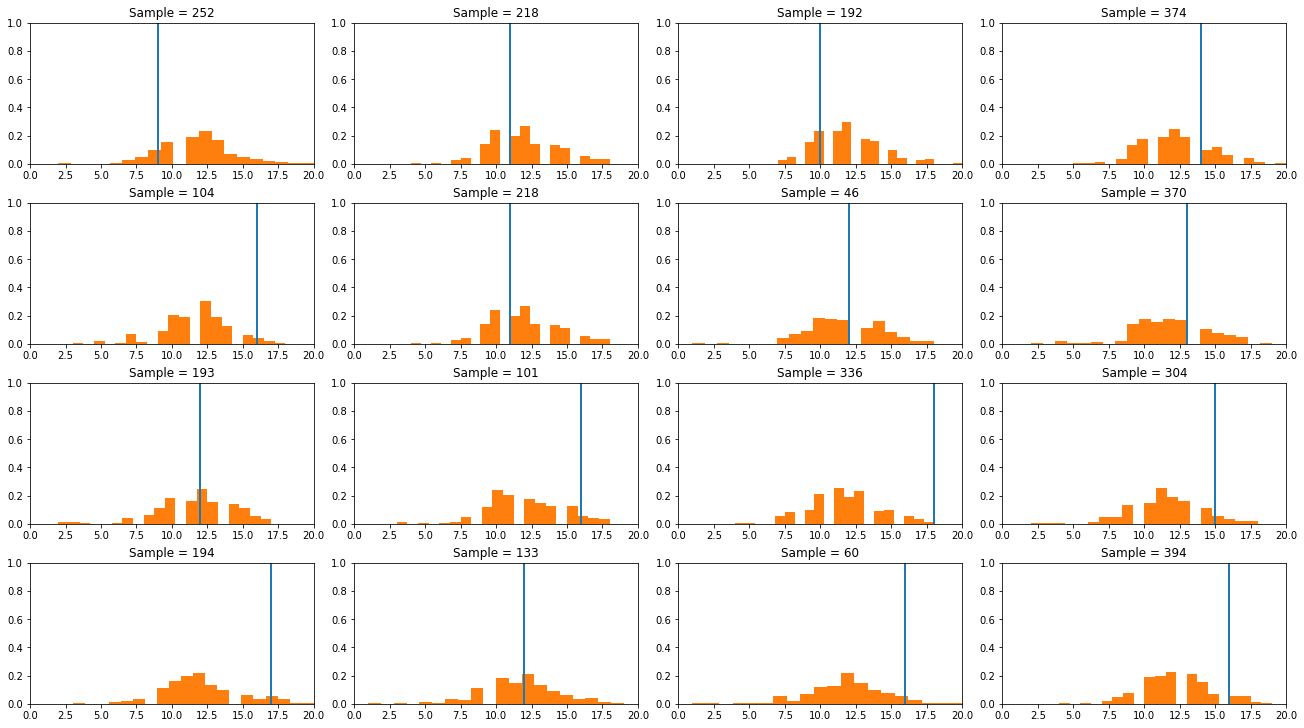

In [26]:
model1ver_fit_final_grade = model1_fit_sim.stan_variable('grade')
arr = np.random.randint(low=1, high=N, size = 16)

fig, axs = plt.subplots(4, 4, figsize=(18, 10), layout='constrained')
for ax, sample in zip(axs.flat, arr):
    x = Final_grade[sample]
    ax.plot([x,x], [-0.2,1.2], linewidth=2, label='real')
    ax.hist(model1ver_fit_final_grade[sample], bins=20, align='mid', density=True, label='predicted')
    ax.set_xlim([0, 20])
    ax.set_ylim([0, 1])
    ax.set_title(f"Sample = {sample}")
plt.show()


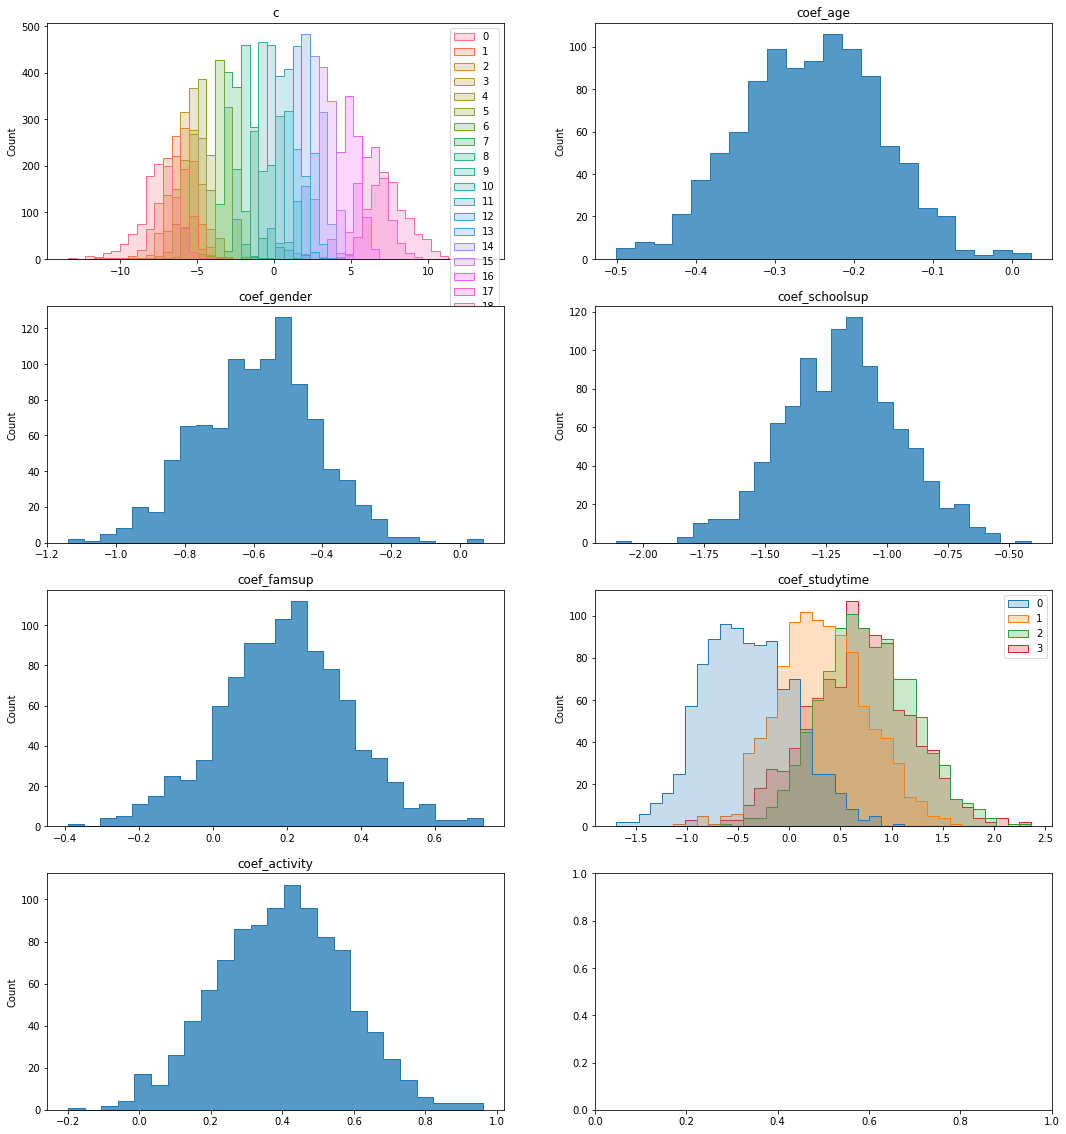

In [27]:
lst = ['c','coef_age','coef_gender','coef_schoolsup','coef_famsup','coef_studytime', 'coef_activity']
fig, axs = plt.subplots(4, 2, figsize=(18, 20))

for ax, param in zip(axs.flat, lst):
 coeffs = model1_fit_sim.stan_variable(param)
 sns.histplot(ax=ax, data=coeffs, element="step")
 ax.set_title(param)

plt.show()



For most paramteters distributions are narrower. Coefficient like famsup, studytime and activity have more impact for final grade than age, gender or extra educational support.

Before making the model, we thought that study time would have an impact on the final grade and, based on the beta parameter, we can see from the plot histogram of the parameter distributions that this is the case.

# 6. Model 2 - Posterior analysis

For second model we have added internet, romantic, traveltime, job mother, job father. These parameters can have impact on final student MeanGrade.

In [28]:
with open('model2_fit.stan') as file:
    print(file.read())

data { 
   // Number of observations
  int<lower=0> N;  

  // Output related data
  int K;  // number of ordinal categories
  array[N] int y;  // ordinal outcome

  // Predictors (1-11)
  array[N] real age_pred;             // Predictor 1 (age)
  array[N] int gender_pred;           // Predictor 2 (gender)
  array[N] int schoolsup_pred;        // Predictor 3 (extra educational support)
  array[N] int famsup_pred;           // Predictor 4 (family educational support)
  array[N] int studytime_pred;        // Predictor 5 (weekly study time)

  array[N] int internet_pred;         // Predictor 6 (Internet access at home)
  array[N] int romantic_pred;         // Predictor 7 (with a romantic relationship)
  array[N] int traveltime_pred;       // Predictor 8 (home to school travel time)
  array[N] int activities_pred;       // Predictor 9 (extra-curricular activities)
  array[N] int Mjob_pred;             // Predictor 10 (mother's job)
  array[N] int Fjob_pred;             // Predictor 11 (fat

In [29]:
model2_fit = CmdStanModel(stan_file='model2_fit.stan')

d = {'N' : N,
     'K' : 20,
     'y' : Final_grade,
     'age_pred' : Age,
     'gender_pred' : Gender,
     'schoolsup_pred' : Schoolsup,
     'famsup_pred' : Famsup,
     'studytime_pred' : Studytime,
     'internet_pred' : Internet,
     'romantic_pred' : Romanitc,
     'traveltime_pred' : Traveltime,
     'activities_pred' : Activities,
     'Mjob_pred' : JobMother,
     'Fjob_pred' : JobFather}

model2_fit_sim = model2_fit.sample(data = d,
                                   iter_sampling=500,
                                   iter_warmup=500,
                                   chains=2,
                                   adapt_delta=0.99,
                                   seed=20230715)


chain 1 |██████████| 03:14 Sampling completed                      
chain 2 |██████████| 03:14 Sampling completed                      

In [30]:
print(model2_fit_sim.diagnose())

Processing csv files: /tmp/tmphc62z64t/model2_fitq3qfqwk0/model2_fit-20230720004658_1.csv, /tmp/tmphc62z64t/model2_fitq3qfqwk0/model2_fit-20230720004658_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



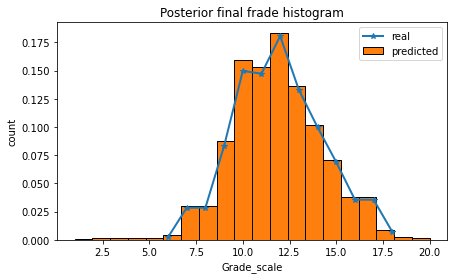

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0   -947.575       0.998754    0.008736          9.0         511.0   
1   -952.136       0.999571    0.008736          9.0         511.0   
2   -944.708       0.999191    0.008736          9.0         511.0   
3   -952.300       0.960260    0.008736          9.0         511.0   
4   -949.059       0.997356    0.008736          9.0         511.0   
..       ...            ...         ...          ...           ...   
995 -943.215       0.981780    0.009377          9.0         511.0   
996 -939.677       0.996512    0.009377          9.0         511.0   
997 -943.964       0.998255    0.009377          9.0         511.0   
998 -952.650       0.996297    0.009377          9.0         511.0   
999 -948.532       1.000000    0.009377          9.0         511.0   

     divergent__  energy__     c[1]     c[2]     c[3]     c[4]     c[5]  \
0            0.0   967.932 -6.29579 -5.17848 -4.81212 -4.47311 -4.37446   
1            0.0   971.893 -7.22356 -6.91602 -6.52124 -6.33017 -5.51457   
2            0.0   970.568 -8.03966 -6.14935 -5.34130 -4.71226 -4.63392   
3            0.0   968.806 -6.68797 -6.13556 -5.81374 -5.65143 -5.58136   
4            0.0   973.662 -9.08568 -7.03669 -5.77551 -5.69877 -5.04663   
..           ...       ...      ...      ...      ...      ...      ...   
995          0.0   966.157 -6.44468 -6.36596 -5.99701 -5.63295 -5.53339   
996          0.0   962.215 -6.16214 -5.36694 -5.13236 -5.11046 -4.89124   
997          0.0   957.318 -6.19802 -6.16881 -5.10573 -4.87485 -4.49127   
998          0.0   972.974 -7.47104 -4.36889 -4.14017 -4.05955 -4.02982   
999          0.0   973.275 -7.75562 -7.74442 -7.36789 -6.64992 -5.29465   

        c[6]     c[7]     c[8]     c[9]     c[10]     c[11]     c[12]  \
0   -4.17543 -3.06695 -2.47503 -1.23524 -0.035497  0.753963  1.746280   
1   -4.19088 -2.79881 -2.38270 -1.45095 -0.366398  0.377538  1.194110   
2   -4.49573 -2.96320 -2.03934 -1.04763  0.144587  0.878771  1.825150   
3   -4.19556 -2.46027 -2.02353 -1.19846 -0.286151  0.498453  1.381200   
4   -4.55723 -2.91304 -2.22595 -1.19229 -0.103840  0.585513  1.543970   
..       ...      ...      ...      ...       ...       ...       ...   
995 -4.90322 -3.94895 -3.31392 -2.33356 -1.208090 -0.551960  0.126589   
996 -4.41804 -2.93424 -2.44706 -1.53313 -0.599443  0.203692  0.894001   
997 -4.18195 -3.36489 -2.89716 -1.74503 -0.569580  0.159265  1.086620   
998 -3.86781 -1.85836 -1.09417 -0.13107  0.851849  1.547170  2.344930   
999 -4.49159 -3.77751 -3.26600 -2.19250 -1.097610 -0.376967  0.550916   

        c[13]    c[14]    c[15]    c[16]    c[17]    c[18]     c[19]  \
0    2.475890  3.06559  3.55694  4.10597  5.53650  8.09869  10.04270   
1    1.817130  2.45717  3.32109  4.16585  5.44806  6.30470   6.38657   
2    2.391320  3.17538  3.95535  4.64479  6.00377  7.06664   7.08731   
3    2.336470  2.80753  3.44733  4.16259  5.59492  7.15121   7.17189   
4    2.425530  2.91557  3.70223  4.51854  6.09120  7.23617   7.45610   
..        ...      ...      ...      ...      ...      ...       ...   
995  0.925948  1.64496  2.34899  2.75996  4.67209  6.26925   7.35755   
996  1.582810  2.31043  3.18688  3.83653  5.36979  6.44973   6.96945   
997  1.865720  2.60344  3.24070  3.73879  5.23550  7.07933   9.03766   
998  2.992110  3.72717  4.39124  5.27902  6.49114  7.65082   8.05023   
999  1.259310  1.89659  2.69610  3.20169  4.56613  5.63575   8.32749   

     coef_age  coef_gender  coef_schoolsup  coef_famsup  coef_studytime[1]  \
0   -0.143631    -0.716720       -1.249120     0.100267           0.101242   
1   -0.305481    -0.761181       -1.477460     0.067662          -0.256671   
2   -0.078829    -1.053890       -1.213290    -0.075256          -0.813125   
3   -0.263943    -0.568941       -1.151950     0.161771          -0.948438   
4   -0.207811    -0.532127       -1.389280     0.330739          -0.660948   
..        ...          ...             ...          ... 

In [31]:
model2_fit_final_grade = model2_fit_sim.stan_variable('grade').flatten()
plt.figure(figsize=(7, 4))

x, y = np.unique(Final_grade, return_counts=True)
plt.plot(x, y/sum(y), marker='*', linewidth=2, label='real')
plt.hist(model2_fit_final_grade, bins=20, align='mid', density=True, label='predicted', edgecolor="black")
plt.title("Posterior final frade histogram")
plt.xlabel("Grade_scale")
plt.ylabel("count")
plt.legend()
plt.show()

df_res = model2_fit_sim.draws_pd()
display(df_res)


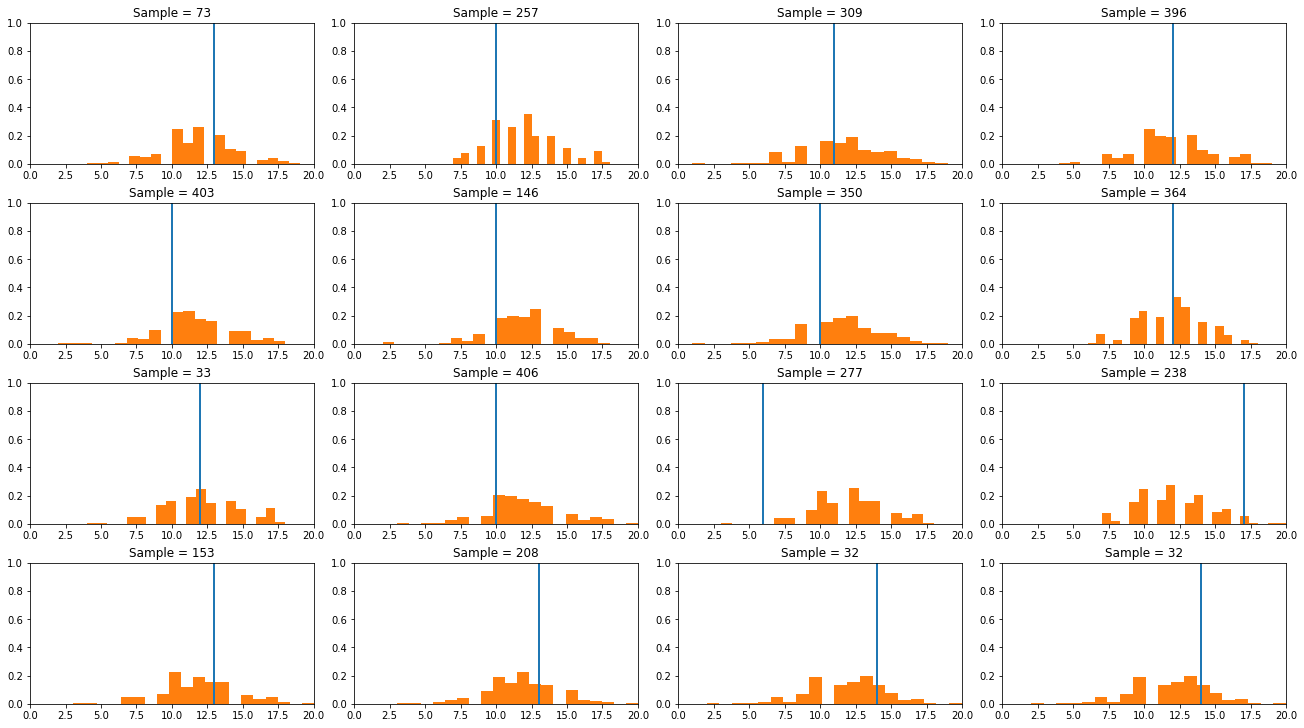

In [32]:
model2ver_fit_final_grade = model2_fit_sim.stan_variable('grade')
arr = np.random.randint(low=1, high=N, size = 16)

fig, axs = plt.subplots(4, 4, figsize=(18, 10), layout='constrained')
for ax, sample in zip(axs.flat, arr):
    x = Final_grade[sample]
    ax.plot([x,x], [-0.2,1.2], linewidth=2, label='real')
    ax.hist(model2ver_fit_final_grade[sample], bins=20, align='mid', density=True, label='predicted')
    ax.set_xlim([0, 20])
    ax.set_ylim([0, 1])
    ax.set_title(f"Sample = {sample}")
plt.show()


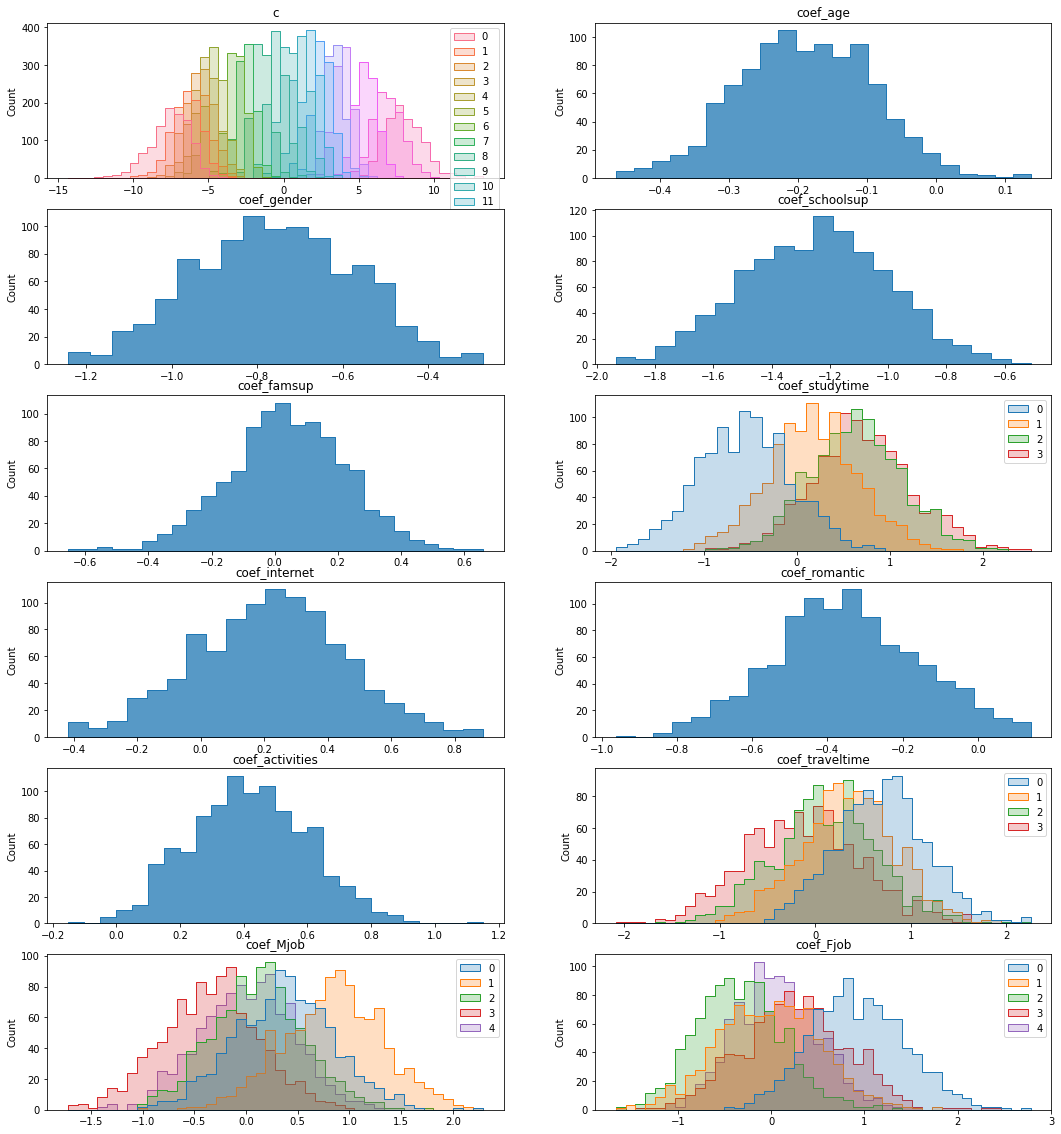

In [33]:
lst = ['c','coef_age','coef_gender','coef_schoolsup','coef_famsup',
       'coef_studytime',  'coef_internet','coef_romantic', 'coef_activities', 'coef_traveltime', 'coef_Mjob', 'coef_Fjob']
fig, axs = plt.subplots(6, 2, figsize=(18, 20))

for ax, param in zip(axs.flat, lst):
 coeffs = model2_fit_sim.stan_variable(param)
 sns.histplot(ax=ax, data=coeffs, element="step")
 ax.set_title(param)

plt.show()

We can see that the work of the mother and father has a major impact on the student's final grade (0 - teacher, 1 - other, 2 - services, 3 - health, 4 - at_home).

The teaching profession of the mother and father has a greater impact than the health profession.






# 7. Model comaprison

### `WAIC` comparision
- Watanabe-Akaike Information Criterion (also known as Widely Applicable Information Criterion, WAIC), which is averages log likelihood and estimates the effective number of paraemeters in the model

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


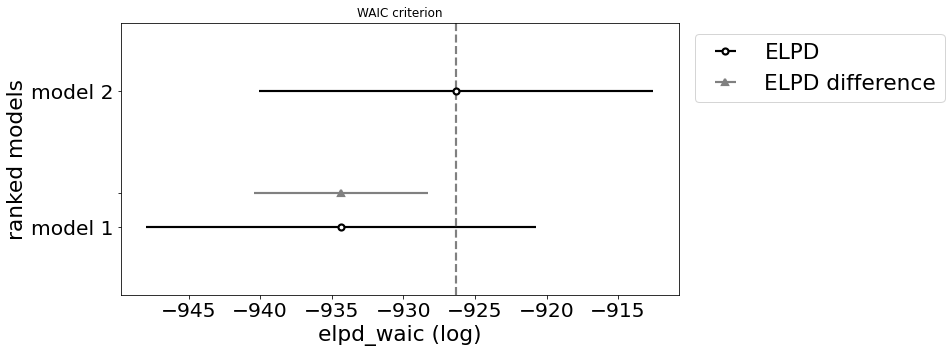

In [34]:
az_pred1 = az.from_cmdstanpy(model1_fit_sim)
az_pred2 = az.from_cmdstanpy(model2_fit_sim)

waic_compare = az.compare({"model 1" : az_pred1, "model 2" : az_pred2}, ic="waic")
az.plot_compare(waic_compare, figsize=(10, 5))
plt.title("WAIC criterion")
plt.show()

In [35]:
display(waic_compare.head())

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model 2,0,-926.322163,31.760798,0.000000,0.731181,13.784926,0.00000,True,log
model 1,1,-934.353107,18.704024,8.030943,0.268819,13.623790,6.05888,True,log


Conclusion:
- In interpreting the WAIC results, a lower elpd_waic value indicates a better fit of the model to the data. In this case, 'Model 2' has a lower elpd_waic (-926.322163) than 'Model 1' (-934.353107), meaning that 'Model 2' fits the data better than 'Model 1'.
- Weight indicates the preference of one model over the others in the comparison. "Model 2" has a higher weight (0.731181) than "Model 1" (0.26541), indicating that "Model 2" is more preferred than "Model 1" over other models.

- Standard errors (SE and DSE) are measures of uncertainty in the estimation of model quality. The DSE (standard error of the elpd_waic difference) shows how accurately we are able to estimate the difference between the model and the best model. In this case, the DSE of 'Model 1' is 6.05888, which means that the difference between 'Model 1' and the best model (in this case 'Model 2') is estimated with a certain level of uncertainty.

- UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. This warning can indicate model misspecification, overfitting, or other issues related to the data or modeling assumptions.

- According to WAIC models are not overlap.

### `PSIS-LOOCV` comparison
- Pareto Smoothed Importance Sampling Leave-one-out Cross Validation. It is an estimate of value obtained from Leave-one-out Cross Validation by using modified importance sampling method instead of running inference N times where N is number of samples, leaving one each time.

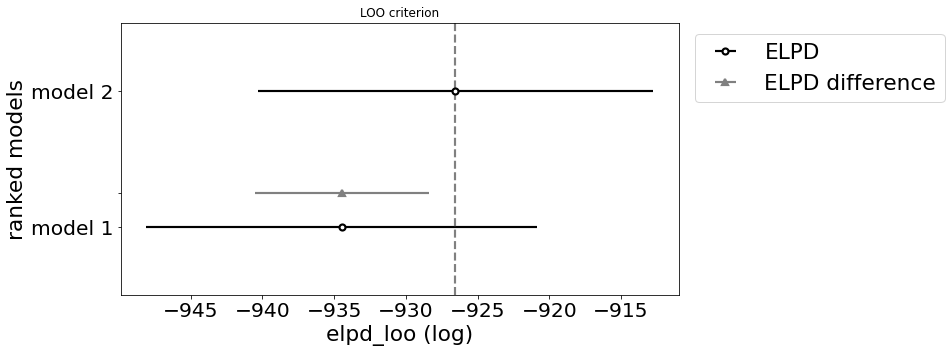

In [36]:
loo_compare = az.compare({"model 1" : az_pred1, "model 2" : az_pred2}, ic="loo")
az.plot_compare(loo_compare, figsize=(10, 5))
plt.title("LOO criterion")
plt.show()

In [37]:
display(loo_compare.head())

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model 2,0,-926.547363,31.985997,0.000000,0.728364,13.798049,0.000000,False,log
model 1,1,-934.483590,18.834508,7.936228,0.271636,13.633662,6.062034,False,log


Conclusion

- From these parameters, we can see that 'Model 2' has a lower elpd_loo value (-926.547363) than 'Model 1' (-934.483590	), implying that 'Model 2' fits the data better.
- In addition, 'Model 2' also has a higher weighting (0.728364) than 'Model 1' (0.271636), suggesting that 'Model 2' is preferred over 'Model 1' when compared to other models.
- Thus, based on the WAIC criterion, 'Model 2' appears to be the better model in the analysis. According to WAIC models are not overlap.